[*********************100%%**********************]  1 of 1 completed
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | RNNModel | 2.3 K 
1 | criterion | MSELoss  | 0     
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


c:\Users\janfr\anaconda3\envs\pytorch_3_10\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 48/48 [00:00<00:00, 125.68it/s, v_num=abng, train_loss_step=0.0738, val_loss_step=0.064, val_loss_epoch=0.0719, train_loss_epoch=0.0635] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 48/48 [00:00<00:00, 65.48it/s, v_num=abng, train_loss_step=0.0738, val_loss_step=0.064, val_loss_epoch=0.0719, train_loss_epoch=0.0635] 


Restoring states from the checkpoint path at .\RNN_single_step_forecasts\prbjabng\checkpoints\epoch=29-step=1440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\RNN_single_step_forecasts\prbjabng\checkpoints\epoch=29-step=1440.ckpt


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 72.47it/s] 14
364
364
364
364


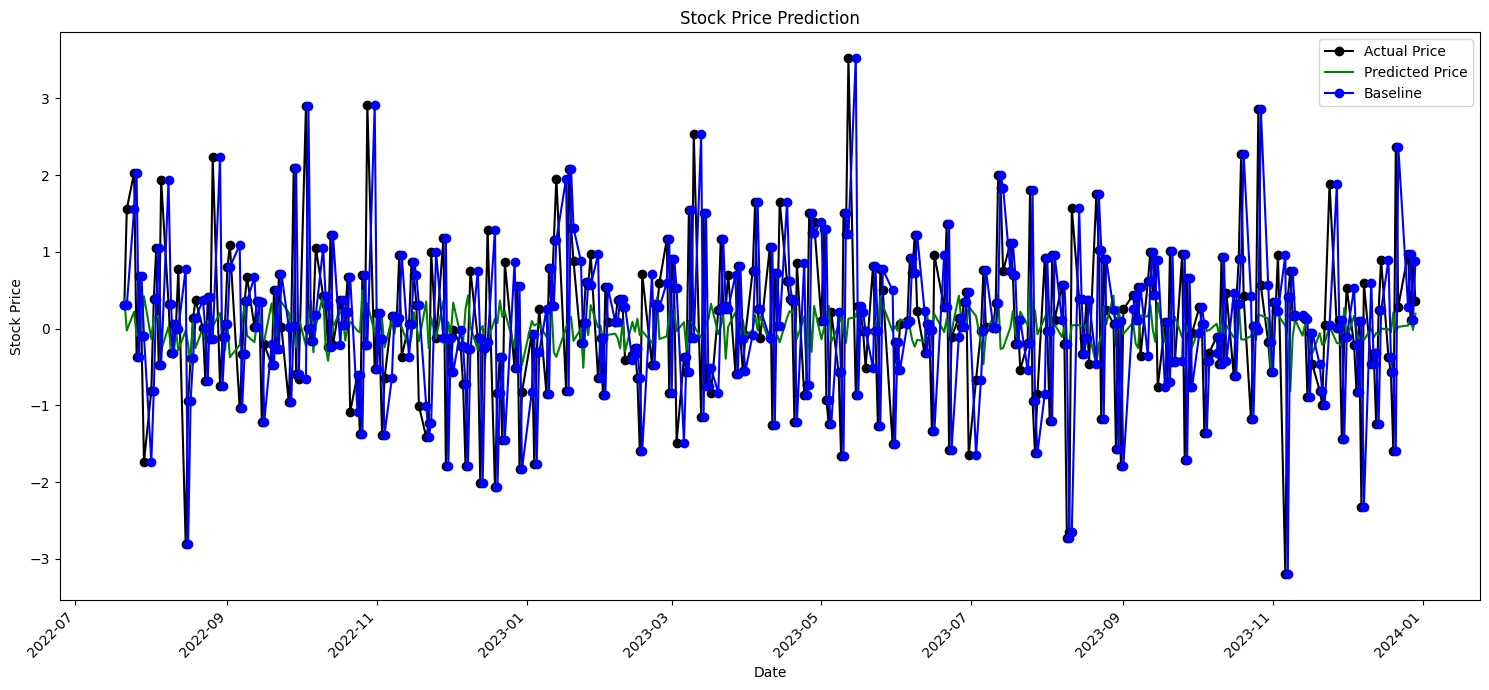

Testing DataLoader 0: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.06318799406290054
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
test_loss,▁
train_loss_epoch,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss_step,▅▃▃▂▂▁▂▂▂▂▂▃▂▂▁▁▁▃▁▃▂█▄▃▅▃▃▂
trainer/global_step,▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▄▄▁▁▅▅▁▂▂▆▂▂▂▂▂▂▇▇▇▂▂██
val_loss_epoch,▂▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▇▇█
val_loss_step,▆█▂▆▆█▂▆▆█▂▂▆█▁▁▆██▁▆▇▇▁▆▆▇▁▆▆▇▁▁▇▇▁▁▇▇▇
epoch,30
test_loss,0.06319
train_loss_epoch,0.06354
train_loss_step,0.03838


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import wandb
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from models import RNNModel, LSTMModel, GRUModel
from config import architecture, seq_length, num_epochs, learning_rate, wandb_config, model_config
from preprocessing import features_df


class StockPredictionModule(pl.LightningModule):
    def __init__(self, model, scaler, scaler_scale, scaler_min, train_loader, val_loader, test_loader, test_dates):
        super().__init__()
        self.model = model
        self.scaler = scaler
        self.scaler_scale = scaler_scale
        self.scaler_min = scaler_min
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.test_dates = test_dates
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        predictions, actuals = [], []
        for seqs, labels in self.test_loader:
            seqs, labels = seqs.to(self.device), labels.to(self.device)
            output = self(seqs)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(labels.view(-1).tolist())
        
        # The second column (index 1) constains the t_close_t_open prices which I consider as the most valuable feature for comparing the predictions of our model
        predictions = np.array(predictions)
        dummy_array = np.zeros((len(predictions), len(self.scaler_scale)))
        dummy_array[:, 1] = predictions
        predictions_original_scale = list(self.scaler.inverse_transform(dummy_array)[:, 1])

        print(len(self.scaler_scale))

        actuals = np.array(actuals)
        dummy_array = np.zeros((len(actuals), len(self.scaler_scale)))
        dummy_array[:, 1] = actuals
        actuals_original_scale = list(self.scaler.inverse_transform(dummy_array)[:, 1])

        baseline_original_scale = [actuals_original_scale[0]] + actuals_original_scale[:-1]

        print(len(predictions_original_scale))
        print(len(actuals_original_scale))
        print(len(baseline_original_scale))
        print(len(self.test_dates))

        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(self.test_dates[-50:], actuals_original_scale[-50:], label='Actual Price', color='black', linestyle='-')
        ax.plot(self.test_dates[-50:], predictions_original_scale[-50:], label='Predicted Price', color='green', linestyle='-')
        ax.plot(self.test_dates[-50:], baseline_original_scale[-50:], label='Baseline', color='blue', linestyle='-')
        ax.set_title('Stock Price Prediction')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.plot()
        plt.show()
        
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        actuals_original_scale = np.array(actuals_original_scale)
        predictions_original_scale = np.array(predictions_original_scale)
        baseline_original_scale = np.array(baseline_original_scale)

        model_mse = mean_squared_error(actuals_original_scale, predictions_original_scale)
        model_rmse = np.sqrt(model_mse)
        model_mae = mean_absolute_error(actuals_original_scale, predictions_original_scale)
        model_r2 = r2_score(actuals_original_scale, predictions_original_scale)
        model_mape = np.mean(np.abs((actuals_original_scale - predictions_original_scale) / actuals_original_scale))
        
        baseline_mse = mean_squared_error(actuals_original_scale, baseline_original_scale)
        baseline_rmse = np.sqrt(baseline_mse)
        baseline_mae = mean_absolute_error(actuals_original_scale, baseline_original_scale)
        baseline_r2 = r2_score(actuals_original_scale, baseline_original_scale)
        baseline_mape = np.mean(np.abs((actuals_original_scale - baseline_original_scale) / (actuals_original_scale + 1e-8)))

        model_metrics = {
            "mse": model_mse,
            "rmse": model_rmse,
            "mae": model_mae,
            "mape": model_mape,
            "r2": model_r2,
        }

        baseline_metrics = {
            "mse": baseline_mse,
            "rmse": baseline_rmse,
            "mae": baseline_mae,
            "mape": baseline_mape,
            "r2": baseline_r2,
        }

        model_baseline_performance_metrics = {
            "mse": round((baseline_mse / model_mse - 1) * 100, 2),
            "rmse": round((baseline_rmse / model_rmse - 1) * 100, 2),
            "mae": round((baseline_mae / model_mae - 1) * 100, 2),
            "mape": round((baseline_mape / model_mape - 1) * 100, 2),
            "r2": round((model_r2 / baseline_r2 - 1) * 100, 2),
        }

        metrics_table = wandb.Table(columns=["metric", "model", "baseline", "model-baseline performance comparison [%]"])
        for metric in model_metrics.keys():
            metrics_table.add_data(metric, model_metrics[metric], baseline_metrics[metric], model_baseline_performance_metrics[metric])
        wandb.log({"metrics": metrics_table})


def create_sequences(data):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length][1]
        xs.append(x)
        ys.append(y)
    xs = np.array(xs)
    ys = np.array(ys).reshape(-1, 1)
    return xs, ys

def flatten_cyclic_features(df, feature_name):
    # Create separate columns for the cosine and sine values
    df[f'{feature_name}_cos'] = df[feature_name].apply(lambda x: x[0])
    df[f'{feature_name}_sin'] = df[feature_name].apply(lambda x: x[1])
    # Drop the original column containing the lists
    df.drop(feature_name, axis=1, inplace=True)
    return df

def load_data():
    stock_df = features_df.copy()
    cyclic_features = ['month_of_year', 'week_of_year', 'day_of_year', 'day_of_month', 'day_of_week']
    for feature in cyclic_features:
        stock_df = flatten_cyclic_features(stock_df, feature)

    split_idx = int(len(stock_df) * 0.8) + seq_length
    train_df = stock_df.iloc[:split_idx]
    temp_df = stock_df.iloc[split_idx:]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_normalized = scaler.fit_transform(train_df)

    X_train, y_train = create_sequences(train_normalized)

    scaler_scale = scaler.scale_.copy()  # save scale
    scaler_min = scaler.min_.copy()  # save min

    temp_normalized = scaler.transform(temp_df)
    X_temp, y_temp = create_sequences(temp_normalized)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    test_dates = stock_df.index[-(len(X_test) + seq_length):].tolist()
    test_dates = test_dates[seq_length:]

    train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False, 
                                               num_workers=15, persistent_workers=True)
    val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False, 
                                             num_workers=15, persistent_workers=True)
    test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False, 
                                              num_workers=15, persistent_workers=True)

    return train_loader, val_loader, test_loader, scaler, scaler_scale, scaler_min, test_dates


def main():
    torch.set_float32_matmul_precision("medium")
    wandb_logger = WandbLogger(project="RNN_single_step_forecasts", log_model="all", config=wandb_config)
    train_loader, val_loader, test_loader, scaler, scaler_scale, scaler_min, test_dates = load_data()

    if architecture == "RNN":
        model = RNNModel(**model_config)
    elif architecture == "LSTM":
        model = LSTMModel(**model_config)
    elif architecture == "GRU":
        model = GRUModel(**model_config)
    else:
        raise ValueError("Unsupported architecture specified")

    module = StockPredictionModule(model=model, scaler=scaler, scaler_scale=scaler_scale, scaler_min=scaler_min, 
                                   train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, test_dates = test_dates)

    # Device agnostic initialization
    if torch.cuda.is_available():   # Check for GPU availability
        accelerator = "gpu"
        devices = 1
    elif hasattr(torch, 'has_mps') and torch.backends.mps.is_built():  # Check for MPS availability (Apple Silicon)
        accelerator = "mps"
        devices = 1
    else:
        accelerator = None  # Defaults to CPU
        devices = None  # Ignored for CPU

    trainer = Trainer(max_epochs=num_epochs, logger=wandb_logger, accelerator=accelerator, devices=devices, enable_checkpointing=True)
    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(dataloaders=test_loader, ckpt_path="best")

    wandb.finish()


if __name__ == "__main__":
    main()

